## Exercise 2.2 - Setting up the model

In a next step the models' architectures need to be defined. The generator is the part of the network that tries to generate a "fake" visible image from the given infra-red image. The discriminator then will try to evaluate if the given image is "real" or "fake". They both try to improve their skills to win this battle.

First, we define some convolutional layers that both the generator and discriminator use. Downsample reduces the input size while increasing the number of filters. Upsample does the opposite - increasing the input size and reducing the number of filters.

In [18]:
# path to project directory
PROJECT_DIR = "/net/merisi/pbigalke/teaching/METFUT2024/CGAN_Pix2Pix_MSG"

# some imports
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.utils import plot_model

# downsample block
def _downsample(filters, size, batchnorm=True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding="same", 
                      kernel_initializer=init, use_bias=False))
    if batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result

# upsample block
def _upsample(filters, size, dropout=False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding="same", 
                               kernel_initializer=init, use_bias=False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result


### (a) The generator

Let's start with the generator. It consists of a number of convolutional layers that first downsample the input (IR image) to a 1D representation and then upsample it again to the original size. The first half extracts features from the infra-red image. The second half generates a fake visible image using the extracted information. To help the network in the more complex part of generating the visible image - skip connections between downsample and upsample layers of the same size are added.

In the following the generator is defined. Print after each layer the shape of the output x.

In [4]:
# definition of generator (complete architecture)
def generator(image_size=128, image_channels=1, kernel_size=4):
    
    # first the layers are defined without calling them

    # define input layer
    inputs = Input(shape = [image_size, image_size, image_channels])
    # define all downsample layers
    down_stack = [
        _downsample(64, kernel_size, batchnorm=False),
        _downsample(128, kernel_size),
        _downsample(256, kernel_size),
        _downsample(512, kernel_size),
        _downsample(512, kernel_size),
        _downsample(512, kernel_size),
        _downsample(512, kernel_size), 
    ]
    
    # define all upsample layers
    up_stack = [
        _upsample(512, kernel_size, dropout=True),
        _upsample(512, kernel_size, dropout=True),
        _upsample(512, kernel_size),
        _upsample(256, kernel_size),  
        _upsample(128, kernel_size), 
        _upsample(64, kernel_size), 
    ]
    # define last output layer
    last = Conv2DTranspose(image_channels, kernel_size, strides=2, padding="same", 
                           kernel_initializer=tf.random_normal_initializer(0., 0.02), 
                           activation="tanh")
    
    # now the layers are put together, each taking the output x of the previous layer as input

    ##### TODO 
    ##### in the following: print the shape of the output at each layer
    #####

    # input x to network
    x = inputs
    print("input layer: ", x.shape)

    # loop over downsample layers
    skips = []
    for down in down_stack:
        # call downsample layer on input x
        x = down(x)
        print("downsample layer: ", x.shape)
        
        # save this output for later creating the skip connections
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # loop over upsample layers
    for up, skip in zip(up_stack, skips):
        # call upsample layer on input x
        x = up(x)
        print("upsample layer: ", x.shape)

        # add skip connection to output x of this layer
        x = Concatenate()([x, skip])
        print("up + skip layer: ", x.shape)
    
    # call last layer
    x = last(x)
    print("last layer: ", x.shape)

    # return model
    return Model(inputs=inputs, outputs=x)


# create a generator model
gen_model = generator()

input layer:  (None, 128, 128, 1)
downsample layer:  (None, 64, 64, 64)
downsample layer:  (None, 32, 32, 128)
downsample layer:  (None, 16, 16, 256)
downsample layer:  (None, 8, 8, 512)
downsample layer:  (None, 4, 4, 512)
downsample layer:  (None, 2, 2, 512)
downsample layer:  (None, 1, 1, 512)
upsample layer:  (None, 2, 2, 512)
up + skip layer:  (None, 2, 2, 1024)
upsample layer:  (None, 4, 4, 512)
up + skip layer:  (None, 4, 4, 1024)
upsample layer:  (None, 8, 8, 512)
up + skip layer:  (None, 8, 8, 1024)
upsample layer:  (None, 16, 16, 256)
up + skip layer:  (None, 16, 16, 512)
upsample layer:  (None, 32, 32, 128)
up + skip layer:  (None, 32, 32, 256)
upsample layer:  (None, 64, 64, 64)
up + skip layer:  (None, 64, 64, 128)
last layer:  (None, 128, 128, 1)


To check if you have spotted all the different layers correctly in the code, you can print a summary of the model and also create an overview plot with tensorflow. 


In [6]:
# print summary of generator model
gen_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 64)           1024      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

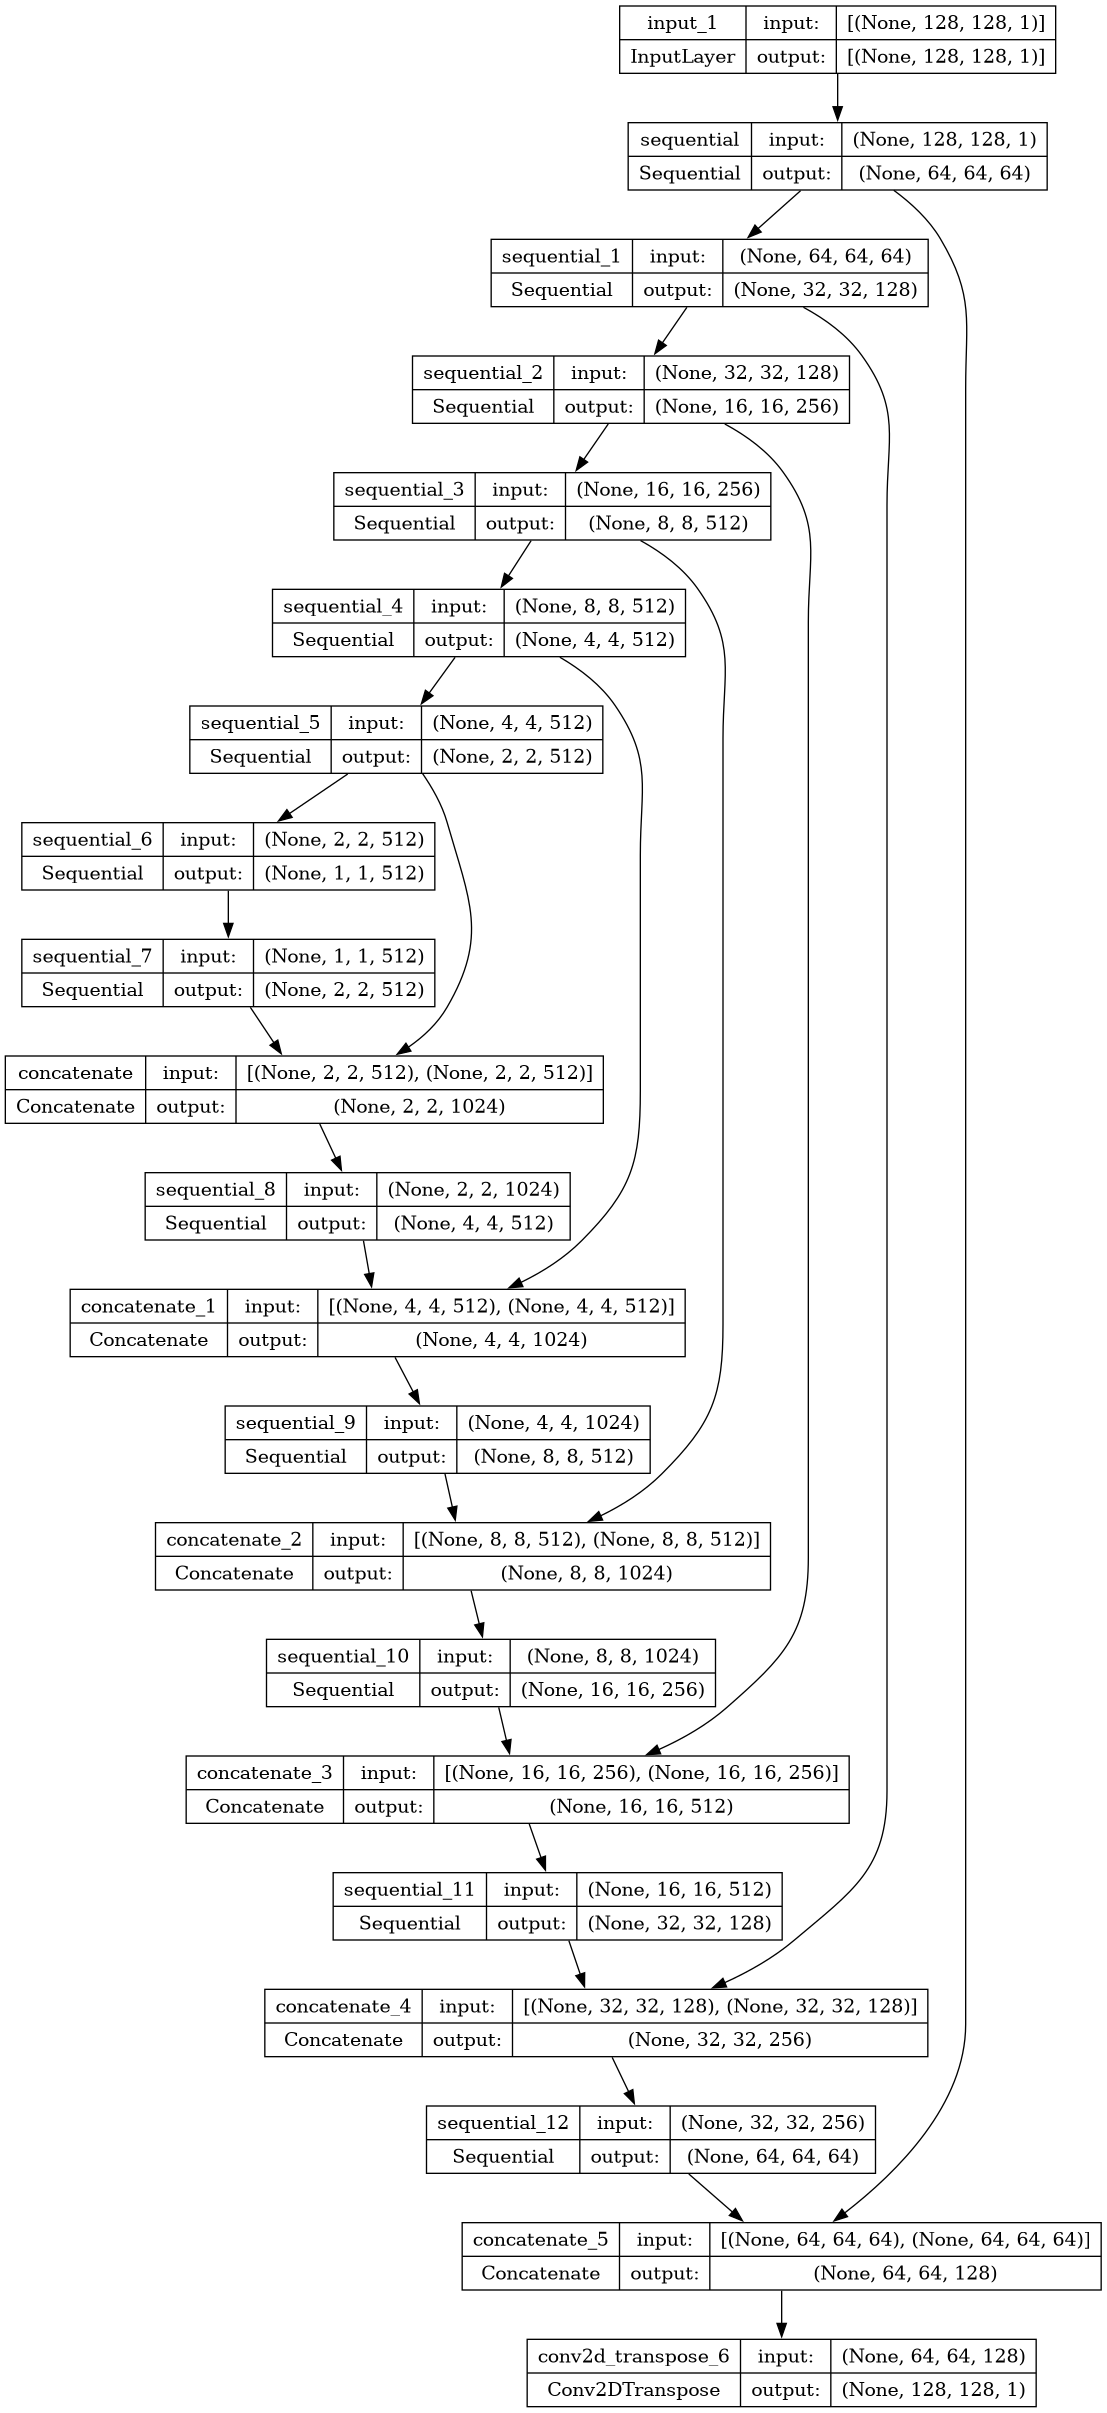

In [16]:
# plot overview of generator model
gen_overview = f"{PROJECT_DIR}/output/model/architecture_generator.png"
plot_model(gen_model,  to_file=gen_overview, show_shapes=True)

### (b) The discriminator

Now coming to the discriminator. Its architecture is a bit simpler. It takes the IR image and a VIS image as input. It samples down to a 1D vector representation. The networks learns to map "real" VIS images onto vectors close to (1, 1, ..., 1) and "fake" VIS images close to (0, 0, ..., 0).

Create a discriminator model and print its summary and overview plot.

In [14]:
# definition of discriminator (complete architecture)
def discriminator(image_size=128, image_channels=1, kernel_size=4):
    init = tf.random_normal_initializer(0., 0.02)
    

    inp = Input(shape = [image_size, image_size, image_channels], name="ir_image")
    tar = Input(shape = [image_size, image_size, image_channels], name="vis_image (real or fake)")
    x = Concatenate()([inp, tar])

    down1 = _downsample(64, kernel_size, batchnorm=False)(x)
    down2 = _downsample(128, kernel_size)(down1)
    down3 = _downsample(256, kernel_size)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, kernel_size, strides=1, 
                  kernel_initializer=init, 
                  use_bias=False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)

    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, kernel_size, strides=1, 
                  kernel_initializer=init)(zero_pad2)

    return Model(inputs=[inp, tar], outputs=last)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ir_image (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 vis_image (real or fake) (  [(None, 128, 128, 1)]        0         []                            
 InputLayer)                                                                                      
                                                                                                  
 concatenate_10 (Concatenat  (None, 128, 128, 2)          0         ['ir_image[0][0]',            
 e)                                                                  'vis_image (real or fake)[0][
                                                                    0]']                    

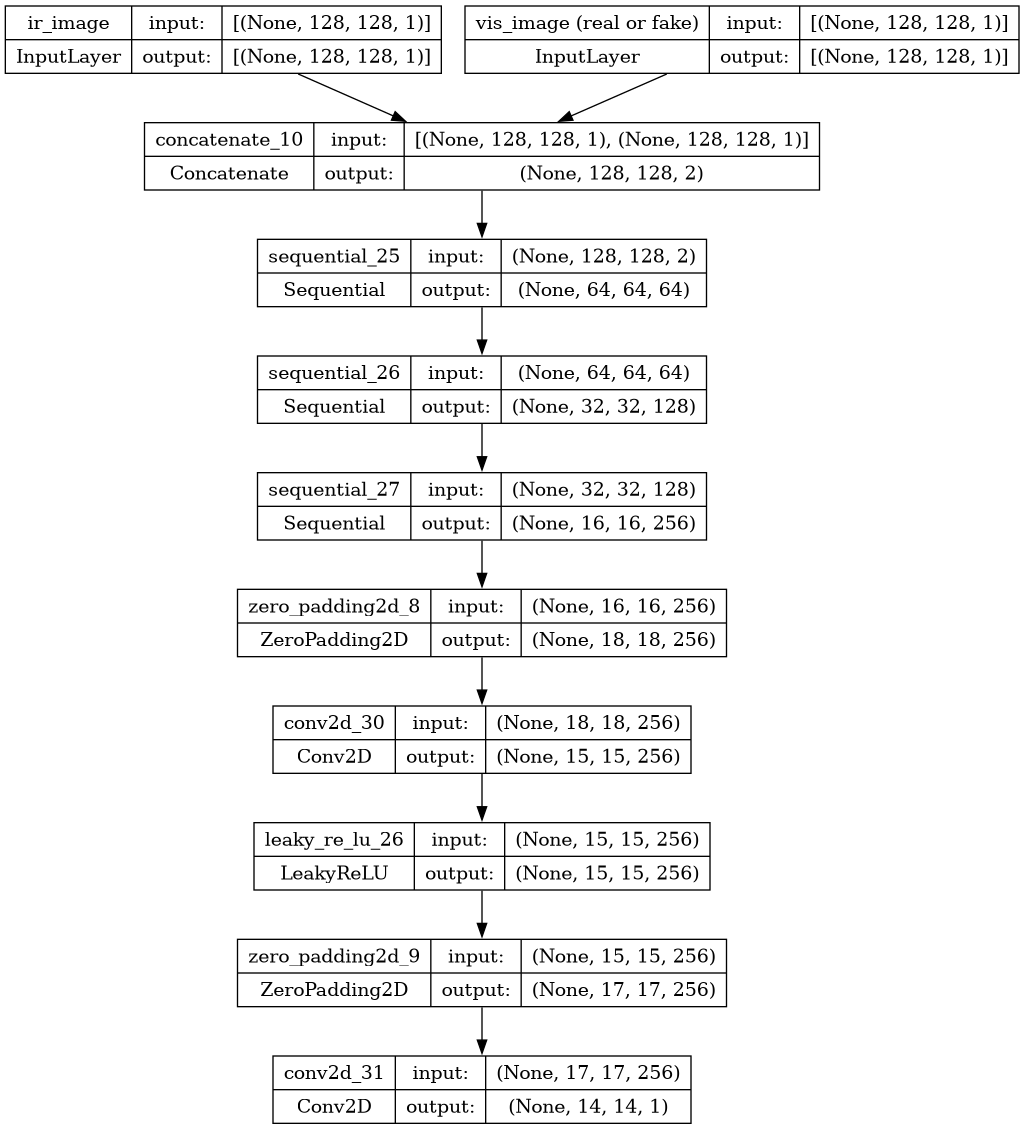

In [19]:
##### TODO
##### create a discriminator model and print a summary and overview plot of the discriminator model
#####
# create a discriminator model
discr_model = discriminator()

# print summary of discriminator model
discr_model.summary()

# plot overview of discriminator model
discr_overview = f"{PROJECT_DIR}/output/model/architecture_discriminator.png"
plot_model(discr_model, to_file=discr_overview, show_shapes=True)
